In [1]:
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN
import numpy as np
import torch

from laplace import Laplace, marglik_training
import torch
from torchvision import datasets, transforms
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import torchvision

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

import torch.nn as nn

import torch.nn.functional as F
import sys
import os

In [2]:
from netcal.metrics import ECE
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN
from laplace.utils import ModuleNameSubnetMask

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
import torch.distributions as dists


In [4]:
py_file_location = "/Users/georgioszefkilis/Bayesian_Deep_Learning/src/utils"
sys.path.append(os.path.abspath(py_file_location))

In [5]:
py_file_location_src = "/Users/georgioszefkilis/Bayesian_Deep_Learning/src/data"
sys.path.append(os.path.abspath(py_file_location_src))

In [6]:
import make_dataset
import AffineTransform
from AffineTransform import make_affine_parameters
import compute_dim
from compute_dim import compute_conv_dim,compute_pool_dim
import SaveLoad
from SaveLoad import save_ckp

In [7]:
if torch.cuda.is_available():
      print("The code will run on GPU.")
else:
      print("The code will run on CPU.")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The code will run on CPU.


In [8]:
config={
            "batch_size": 256,
            "num_classes": 10,
            "channels": 1,
            "filter1_out": 16,
            "kernel_size": 5,
            "pool": 2,
            "filter2_out": 32,
            "padding": 0,
            "stride": 1,
            "learning_rate_base": 0.001,
            "learning_rate_stn":0.0001,
            "epochs": 5,
            "crop_size": 128,
            "enc_sizes":[16,32,64],
            "loc_sizes":[8,16,32,64],
        }


In [9]:
train_loader,_,test_loader = make_dataset.data(config["batch_size"],config["crop_size"],misplacement=True,load=True,save=False)

Train_data 42000
Validation_data 18000
Test_data 10000


Feature batch shape: torch.Size([256, 1, 128, 128])
Labels batch shape: torch.Size([256])


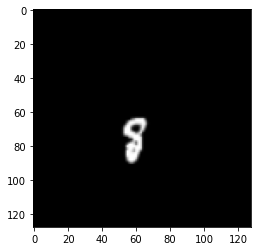

Label: 8


In [10]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[1].squeeze()
label = train_labels[1]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [14]:
def conv_block(in_f, out_f, *args, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_f, out_f, *args, **kwargs),
        nn.MaxPool2d(2, stride=2),
        nn.BatchNorm2d(out_f),
        nn.ReLU()
    )


class Base(nn.Module):
    def __init__(self, enc_sizes,kernel,pad):
        super().__init__()

        conv_blocks =[conv_block(in_f, out_f, kernel_size=kernel, padding=pad) 
                       for in_f, out_f in zip(enc_sizes, enc_sizes[1:])]

        self.base_net = nn.Sequential(*conv_blocks)
        

    def forward(self,x):
        x = self.base_net(x)
    
        return x


class STN(nn.Module):
    def __init__(self,loc_sizes,kernel,pad, parameterize=True):
        super().__init__()
    
        self.parameterize =parameterize 
        self.loc_sizes = loc_sizes
        
        
        conv_blocks =[conv_block(in_f, out_f, kernel_size=kernel, padding=pad) 
                        for in_f, out_f in zip(loc_sizes, loc_sizes[1:])]

        self.localization = nn.Sequential(*conv_blocks)
        

        # Regressor for the affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(loc_sizes[-1] * 4 * 4, 32),
            nn.ReLU(),
            nn.Linear(32, 2 * 1 if parameterize else 3 * 2),
        )
        
        self.fc_loc[-1].weight.data.zero_()
        if parameterize:
            bias = torch.tensor([0, 0], dtype=torch.float)
            self.fc_loc[-1].bias.data.copy_(bias[:2].view(-1))

        else:
            self.fc_loc[-1].bias.data.copy_(
                torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float)
            )
        

    def forward(self,x):
        xs = self.localization(x)
        #print(xs.shape)
        xs = xs.view(-1, self.loc_sizes[-1] * xs.shape[2] * xs.shape[3])

        theta = self.fc_loc(xs)

        if self.parameterize:
            theta = AffineTransform.make_affine_parameters(theta)
        else:
            theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(), align_corners=True)
        x = F.grid_sample(x, grid)

        return x

class Net(nn.Module):
    def __init__(self, in_c, enc_sizes, loc_sizes,kernel,pad, n_classes,parameterize=True):
        super().__init__()
    
        self.enc_sizes = [in_c, *enc_sizes]
        self.loc_sizes = [in_c, *loc_sizes]
        self.kernel = kernel
        self.pad =pad

        self.parameterize = parameterize
        self.n_classes = n_classes
        
        self.base = Base(self.enc_sizes, self.kernel, self.pad)
        self.stn = STN(self.loc_sizes, self.kernel, self.pad, self.parameterize)
        self.fc1 = nn.Linear(
            self.enc_sizes[-1] * 12* 12 , 50
        )
        self.fc2 = nn.Linear(50, self.n_classes)
        

    def forward(self,x):
        # transform the input
        #print('input_stn',x.shape)
        x = self.stn(x)
        #print('stn_out',x.shape)

        x = self.base(x)
        #print('out_base',x.shape)
        
        #x = x.view(-1, self.enc_sizes[-1] * 4 * 4)
        x = x.flatten(1)
        #print('exp',y.shape)
        #print('flat',x.shape)
        x = F.relu(self.fc1(x))
        #print('linea_out',x.shape)
        
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #print('net_out',x.shape)

        return x



In [15]:
model = Net(
        config["channels"],
        config["enc_sizes"],
        config["loc_sizes"],
        config["kernel_size"],
        config["padding"],
        config["num_classes"],
        parameterize=True).to(device).eval()

In [16]:
model_path = '/Users/georgioszefkilis/Bayesian_Deep_Learning/saved_models/STN_MNIST_10_HPC.pth'
checkpoint = torch.load(model_path, map_location=device)
    # initialize state_dict from checkpoint to model
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [17]:
@torch.no_grad()
def predict(dataloader, model, laplace=False):
    py = []
    target = []
    for x, t in dataloader:
        x,t = x.to(device),t.to(device)
        target.append(t)
        if laplace:
            py.append(model(x))
        else:
            py.append(torch.softmax(model(x), dim=-1))

    images = torch.cat(py).cpu()
    labels =torch.cat(target, dim=0).cpu()
    acc_map = (images.argmax(-1) == labels).float().mean()
    ece_map = ECE(bins=15).measure(images.numpy(), labels.numpy())
    nll_map = -dists.Categorical(images).log_prob(labels).mean()
    
    return acc_map,ece_map,nll_map

# Last Layer Implementation

## Without Laplace

In [19]:
acc_map,ece_map,nll_map = predict(test_loader,model,laplace=False)
print(f"[MAP] Acc.: {acc_map:.1%}; ECE: {ece_map:.1%}; NLL: {nll_map:.3}")


/Users/georgioszefkilis/anaconda3/anaconda3/envs/Bayesian_DL/lib/python3.8/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[MAP] Acc.: 98.4%; ECE: 5.5%; NLL: 0.106


## With Laplace

In [20]:
la = Laplace(model, 'classification',
             subset_of_weights='last_layer',
             hessian_structure='kron')
la.fit(train_loader)
la.optimize_prior_precision(method='marglik')

arxidia
maniaou
iiiieeeiii


In [21]:
acc_laplace,ece_laplace,nll_laplace = predict(test_loader, la, laplace=True)

print(
        f"[Laplace] Acc.: {acc_laplace:.1%}; ECE: {ece_laplace:.1%}; NLL: {nll_laplace:.3}"
    )

[Laplace] Acc.: 98.4%; ECE: 28.5%; NLL: 0.41


# Subnetwork Laplace

In [73]:


print('start_laplace')
subnetwork_mask = ModuleNameSubnetMask(model, module_names=['stn.fc_loc.2'])
print('step 2')
subnetwork_mask.select()
print('step 3')
subnetwork_indices = subnetwork_mask.indices
print('step 4')
sub_la = Laplace(
    model,
    "classification",
    subset_of_weights="subnetwork",
    hessian_structure="full",
    subnetwork_indices = subnetwork_indices#.type(torch.LongTensor),
)
print('fit')
sub_la.fit(train_loader)
print('optimize')
sub_la.prior_precision=torch.tensor([0.0001])

#la.optimize_prior_precision(method="marglik")






start_laplace
step 2
step 3
step 4
fit


/Users/georgioszefkilis/anaconda3/anaconda3/envs/Bayesian_DL/lib/python3.8/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/georgioszefkilis/anaconda3/anaconda3/envs/Bayesian_DL/lib/python3.8/site-packages/backpack/extensions/backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.Net'> although the module has parameters
  warnings.warn(
/Users/georgioszefkilis/anaconda3/anaconda3/envs/Bayesian_DL/lib/python3.8/site-packages/backpack/extensions/backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.Base'> although the module has parameters
  warnings.warn(
/Users/georgioszefkilis/anaconda3/anaconda3/envs/Bayesia

KeyboardInterrupt: 

In [32]:
la.prior_precision=torch.tensor([0.000001])
#la.optimize_prior_precision(method="marglik")



In [33]:
la_accuracy,acc_map,ece_map,nll_map = predict(sub_la,test_loader,laplace=True)



Test set: Accuracy: 9950.0/10000 (100%)

Acc.: 100.0%; ECE: 0.0%; NLL: 2.97e-06


In [30]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

/Users/georgioszefkilis/anaconda3/anaconda3/envs/Bayesian_DL/lib/python3.8/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


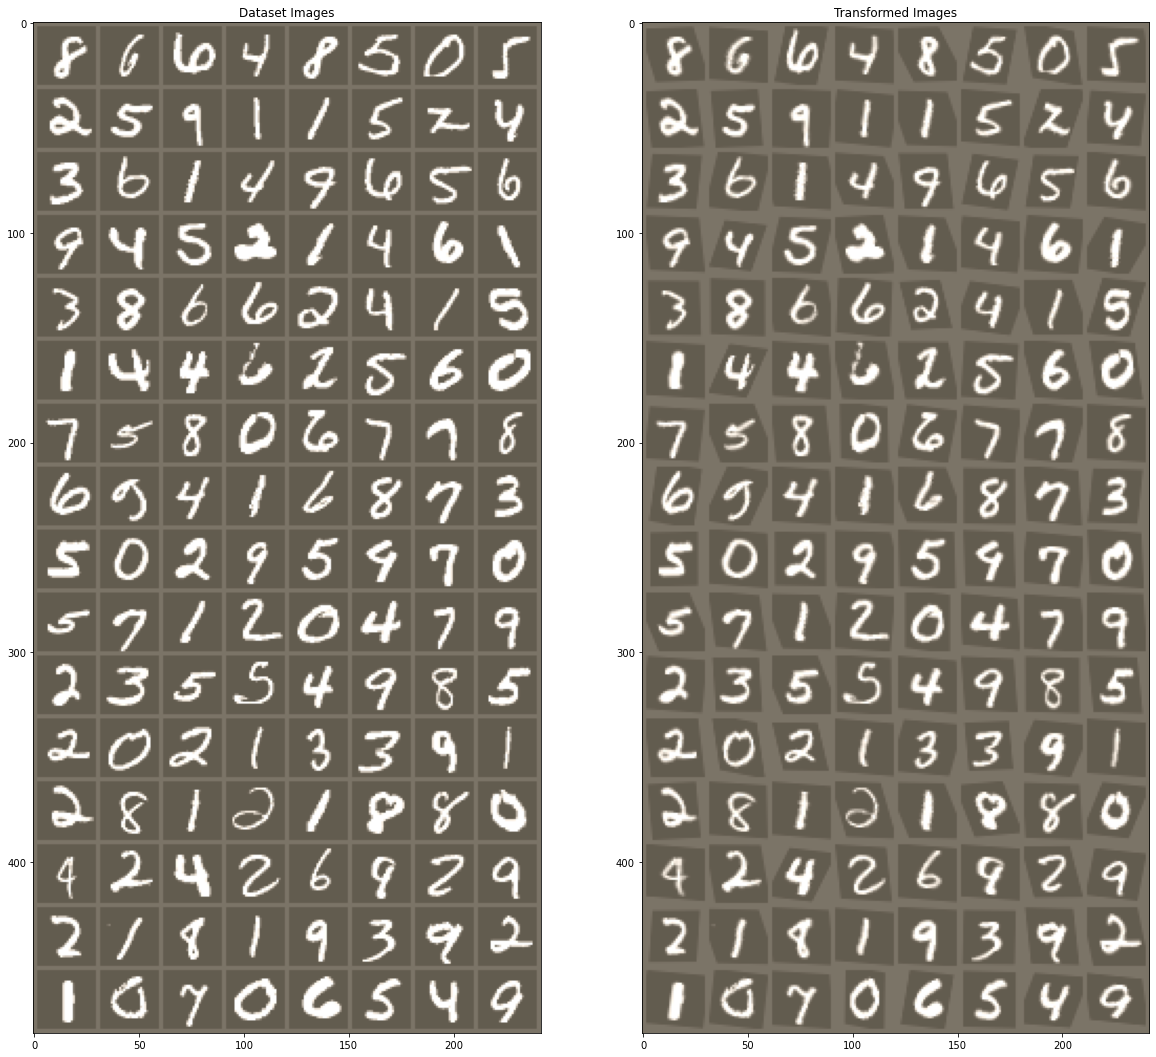

In [57]:
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        
        transformed_input_tensor = la.model.stn(data).cpu()
        

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
             torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2,figsize=(20,20))
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')



# Visualize the STN transformation on some input batch
visualize_stn()
#wandb.log({'Final':wandb.Image(visualize_stn)})

plt.ioff()
plt.show()

In [21]:
test_feature,test_labels =next(iter(test_loader))

In [59]:
input_tensor = []
transformed_input_tensor=[]
for i,j in enumerate(test_labels):
    if j ==1:
      input_tensor.append(test_feature[i])
      transformed_input_tensor.append(test_feature[i])
    else:
      pass

in_grid = convert_image_np(
    torchvision.utils.make_grid(input_tensor[0]))

out_grid = convert_image_np(
    torchvision.utils.make_grid(la.model.stn(transformed_input_tensor[0]).cpu()))

# Plot the results side-by-side
f, axarr = plt.subplots(1, 2,figsize=(20,20))
axarr[0].imshow(in_grid)
axarr[0].set_title('Negative')

axarr[1].imshow(out_grid)
axarr[1].set_title('Metastasis')

plt.ioff()
plt.show()


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [8, 1, 5, 5], but got 3-dimensional input of size [1, 28, 28] instead

In [54]:
for i in input_tensor:
    print(torch.cat(i))

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [43]:
with torch.no_grad():
    conv = la.model.stn(data[0]).cpu()
    conv = convert_image_np(conv)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [8, 1, 5, 5], but got 3-dimensional input of size [1, 28, 28] instead

In [38]:
plt.imshow(model(conv).cpu())
plt.show()

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


In [23]:
la.optimize_prior_precision(method="marglik")

RuntimeError: The size of tensor a (47108) must match the size of tensor b (198) at non-singleton dimension 0

/Users/georgioszefkilis/anaconda3/anaconda3/envs/Bayesian_DL/lib/python3.8/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/georgioszefkilis/anaconda3/anaconda3/envs/Bayesian_DL/lib/python3.8/site-packages/backpack/extensions/backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.Net'> although the module has parameters
  warnings.warn(
/Users/georgioszefkilis/anaconda3/anaconda3/envs/Bayesian_DL/lib/python3.8/site-packages/backpack/extensions/backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.Base'> although the module has parameters
  warnings.warn(
/Users/georgioszefkilis/anaconda3/anaconda3/envs/Bayesia

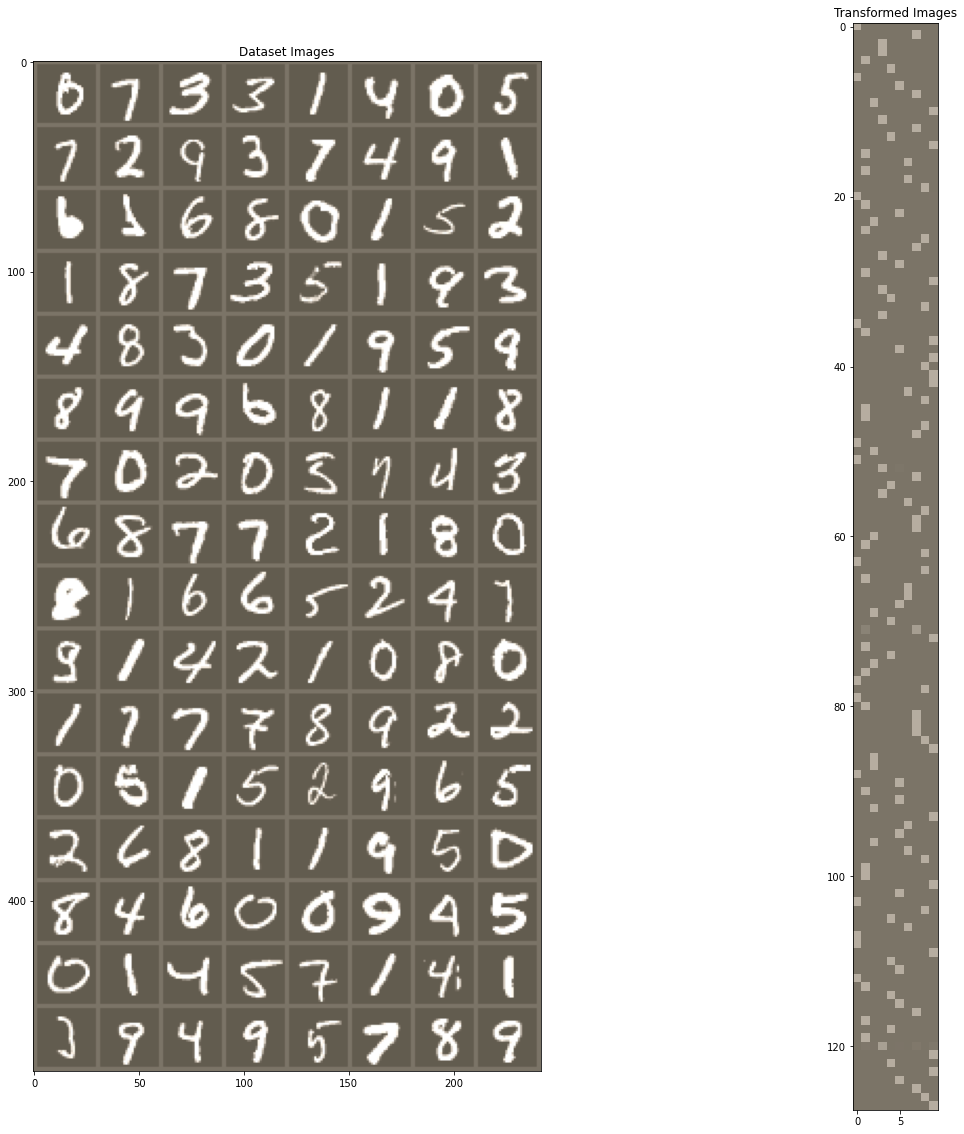

In [19]:
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = la(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2,figsize=(20,20))
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')



# Visualize the STN transformation on some input batch
visualize_stn()
#wandb.log({'Final':wandb.Image(visualize_stn)})

plt.ioff()
plt.show()